<center>
<h1><b>Information Theory</b></h1>
<h3>Lab 4: Conditional entropy of natural languages</h3>
<h4>Maksymilian Norkiewicz 160267</h4>
<h4>Lecturer: Iwo Błądek<h4>
</center>

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

# Main class for language entropy

$$
p(y|x) = \frac{p(x, y)}{p(x)}
$$

$$
H(Y|X) = -\sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot \log_{2}(p(y|x)) = -\sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot \log_{2}(\frac{p(x, y)}{p(x)})
$$

In [2]:
class LanguageDetection():
    def __init__(self, text:str):
        if os.path.exists(text):
            with open(text, "r") as f:
                self.text = f.read()
        else:
            self.text = text

        self._text_length = len(self.text)
        self.signs_frequency = {}
        self.pairs_frequency = {}
        self.text_entropy = None
        self.conditional_entropies = None

        self._count_signs()
        self._count_frequency()
        self._count_entropy()

    def _count_signs(self):
        for i in range(self._text_length):
            if not i == 0:
                if self.text[i-1:i+1] in self.pairs_frequency:
                    self.pairs_frequency[self.text[i-1:i+1]] += 1
                else:
                   self.pairs_frequency[self.text[i-1:i+1]] = 1
            if self.text[i] in self.signs_frequency:
                self.signs_frequency[self.text[i]] += 1
            else:
                self.signs_frequency[self.text[i]] = 1

    def _count_frequency(self):
        for sign in self.signs_frequency.keys():
            self.signs_frequency[sign] /= self._text_length

        for pair in self.pairs_frequency.keys():
            self.pairs_frequency[pair] /= (self._text_length - 1)


    def _count_entropy(self):
        conditional_entropy = 0
        for pair, p_xy in self.pairs_frequency.items():
            x = pair[0]
            p_x = self.signs_frequency[x]

            p_y_given_x = p_xy / p_x

            conditional_entropy -= p_xy * math.log2(p_y_given_x)

        self.text_entropy = conditional_entropy

# Entropy for languages from Wikipedia

In [59]:
translate = {
    'en': "Eglish",
    'eo': "Esperanto",
    'et': "Estonian",
    'ht': "Haitian",
    'la': "Latin",
    'nv': "Navaho",
    'so': "Somali"
}

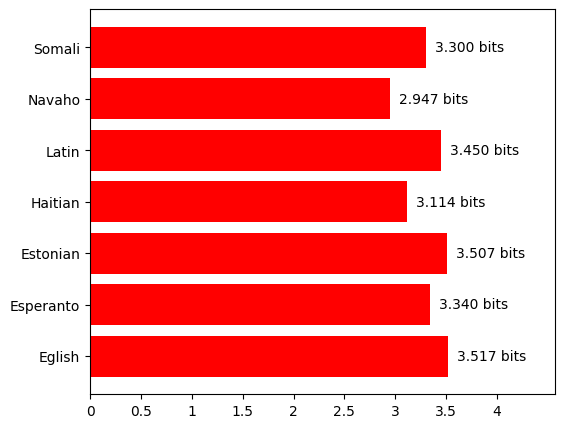

In [60]:
results = {}

for file in os.listdir("./data/wiki"):
    language = file.split("_")[-1].split(".")[0]
    entropy = LanguageDetection(f"./data/wiki/{file}").text_entropy
    results[language] = entropy

mean_language_entropy = sum(results.values()) / len(results)

plt.figure(figsize=(6, 5))
for i, (_, entropy) in enumerate(results.items()):
    plt.barh(i, entropy, color="red")
    plt.text(entropy+0.025*max(list(results.values())), i, f"{entropy:.3f} bits", va="center")
plt.xticks(np.arange(0, 4.1, 0.5), [f"{v:.0f}" if v % 1 == 0 else f"{v}" for v in np.arange(0, 4.1, 0.5)])
plt.yticks(np.arange(len(results)), [translate[lang] for lang in list(results.keys())])
plt.xlim(0, max(list(results.values()))*1.3)
plt.show()

# Entropy for samples languages

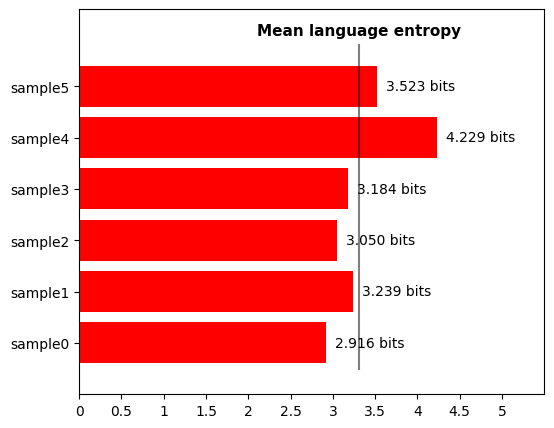

In [ ]:
results = {}

for file in os.listdir("./data/samples"):
    sample_name = file.split(".")[0]
    entropy = LanguageDetection(f"./data/samples/{file}").text_entropy
    results[sample_name] = entropy

plt.figure(figsize=(6, 5))
for i, (_, entropy) in enumerate(results.items()):
    plt.barh(i, entropy, color="red")
    plt.text(entropy+0.025*max(list(results.values())), i, f"{entropy:.3f} bits", va="center")
plt.xticks(np.arange(0, 5.1, 0.5), [f"{v:.0f}" if v % 1 == 0 else f"{v}" for v in np.arange(0, 5.1, 0.5)])
plt.plot([mean_language_entropy]*2, [-0.5, len(results)-0.2], c="k", alpha=0.5)
plt.yticks(np.arange(len(results)), list(results.keys()))
plt.xlim(0, max(list(results.values()))*1.3)
plt.ylim(-1, len(results)+0.5)
plt.text(mean_language_entropy, len(results), "Mean language entropy", fontsize=11, ha="center", weight="600")
plt.show()

In [54]:
difference = abs(mean_language_entropy - results["sample4"]) / mean_language_entropy
print(f"Difference between sample4 and mean leanguage entropy: {difference*100:.0f}%")

Difference between sample4 and mean leanguage entropy: 28%


Samples `sample0`, `sample1`, `sample2`, `sample3`, `sample5` can be real languages, because the entropy of these languages are near to the mean entropy of the real languages, but the `sample4` probably is not a real language, because the difference between their entropy and the mean entropy of real languages is 28%.